In [30]:
# uci_digits_auto_anomaly.py

# autoencoder reconstruction error anomaly detection
# uses an encoder-decoder architecture
# PyTorch 1.8.0-CPU Anaconda3-2020.02  Python 3.7.6
# Windows 10 

import numpy as np
import matplotlib.pyplot as plt
import torch as T

device = T.device("cpu") 
print(device)

cpu


In [2]:
# -----------------------------------------------------------

class UCI_Digits_Dataset(T.utils.data.Dataset):
  # 8,12,0,16, . . 15,7
  # 64 pixel values [0-16], digit [0-9]

  def __init__(self, src_file, n_rows=None):
    all_xy = np.loadtxt(src_file, max_rows=n_rows,
      usecols=range(0,65), delimiter=",", comments="#",
      dtype=np.float32)
    self.xy_data = T.tensor(all_xy, dtype=T.float32).to(device) 
    self.xy_data[:, 0:64] /= 16.0   # normalize pixels
    self.xy_data[:, 64] /= 9.0      # normalize digit/label

  def __len__(self):
    return len(self.xy_data)

  def __getitem__(self, idx):
    xy = self.xy_data[idx]
    return xy

# -----------------------------------------------------------

In [3]:
# -----------------------------------------------------------

class Autoencoder(T.nn.Module):  # 65-32-8-32-65
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.fc1 = T.nn.Linear(65, 32)
    self.fc2 = T.nn.Linear(32, 8)
    self.fc3 = T.nn.Linear(8, 32)
    self.fc4 = T.nn.Linear(32, 65)

  def encode(self, x):  # 65-32-8
    z = T.tanh(self.fc1(x))
    z = T.tanh(self.fc2(z))  # latent in [-1,+1]
    return z  

  def decode(self, x):  # 8-32-65
    z = T.tanh(self.fc3(x))
    z = T.sigmoid(self.fc4(z))  # [0.0, 1.0]
    return z
    
  def forward(self, x):
    z = self.encode(x) 
    z = self.decode(z) 
    return z  # in [0.0, 1.0]

# -----------------------------------------------------------


In [36]:
# -----------------------------------------------------------

def display_digit(ds, idx, save=False):
  # ds is a PyTorch Dataset
  line = ds[idx]  # tensor
  pixels = np.array(line[0:64])  # numpy row of pixels
  label = np.int_(line[64] * 9.0)  # denormalize; like '5'
  print("\ndigit = ", str(label), "\n")

  pixels = pixels.reshape((8,8))
  for i in range(8):
    for j in range(8):
      pxl = pixels[i,j]  # or [i][j] syntax
      pxl = np.int_(pxl * 16.0)  # denormalize
      print("%.2X" % pxl, end="")
      print(" ", end="")
    print("")

  plt.imshow(pixels, cmap=plt.get_cmap('gray_r'))
  if save == True:
    plt.savefig(".\\idx_" + str(idx) + "_digit_" + \
    str(label) + ".jpg", bbox_inches='tight')
  plt.show() 
  plt.close() 

# -----------------------------------------------------------



In [5]:

def display_digits(ds, idxs, save=False):
  # idxs is a list of indices
  for idx in idxs:
    display_digit(ds, idx, save)

# -----------------------------------------------------------

In [6]:

def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")

# -----------------------------------------------------------


In [7]:

def make_err_list(model, ds):
  # assumes model.eval()
  result_lst = []
  n_features = len(ds[0])  # 65
  for i in range(len(ds)):
    X = ds[i]
    with T.no_grad():
      Y = model(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
  return result_lst 

# -----------------------------------------------------------

In [21]:
# 0. get started
print("\nBegin UCI Digits autoencoder anomaly demo ")
T.manual_seed(1)
np.random.seed(1)

# 1. create Dataset object
print("\nLoading data as normalized tensors ")
fn = ".\\Data\\optdigits_train_3823.txt"
data_ds = UCI_Digits_Dataset(fn)  # all rows



Begin UCI Digits autoencoder anomaly demo 

Loading data as normalized tensors 


In [22]:
print(type(data_ds.__getitem__(1125)))
print(len(data_ds))

<class 'torch.Tensor'>
3823


In [23]:
def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")


In [24]:

# 2. create autoencoder net
print("\nCreating a 65-32-8-32-65 autoencoder ")
autoenc = Autoencoder().to(device)
autoenc.train()   # set mode




Creating a 65-32-8-32-65 autoencoder 


Autoencoder(
  (fc1): Linear(in_features=65, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=65, bias=True)
)

In [25]:
# 3. train autoencoder model
bat_size = 10
max_epochs = 100
log_interval = 10
lrn_rate = 0.005

print("\nbat_size = %3d " % bat_size)
print("max epochs = " + str(max_epochs))
print("loss = MSELoss")
print("optimizer = SGD")
print("lrn_rate = %0.3f " % lrn_rate)






bat_size =  10 
max epochs = 100
loss = MSELoss
optimizer = SGD
lrn_rate = 0.005 


In [ ]:
train(autoenc, data_ds, bat_size, max_epochs, \
log_interval, lrn_rate) 

In [38]:
filepath = "../../../BottlesAnomalies_TFM/models/pytorchModels/UCI_digitsModel1"


In [ ]:
T.save(autoenc.state_dict(), filepath)

In [39]:
# For loading the model 
autoenc.load_state_dict(T.load(filepath))
autoenc.eval()

Autoencoder(
  (fc1): Linear(in_features=65, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=65, bias=True)
)

In [28]:
# 4. compute and store reconstruction errors
print("\nComputing reconstruction errors ")
autoenc.eval()  # set mode
err_list = make_err_list(autoenc, data_ds)
err_list.sort(key=lambda x: x[1], \
reverse=True)  # high error to low




Computing reconstruction errors 


Largest reconstruction item / error: 
 [ 486]  0.1352

digit =  7 

00 00 00 0A 10 10 10 09 
00 00 00 02 05 0A 10 0C 
00 00 00 00 00 06 10 02 
00 00 00 00 00 0E 0A 00 
00 01 08 0E 10 10 05 00 
00 05 0A 08 10 0A 01 00 
00 00 00 05 0E 01 00 00 
00 00 00 0D 09 00 00 00 


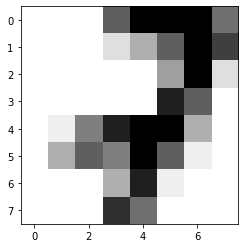


End autoencoder anomaly detection demo 



In [37]:
# 5. show most anomalous item
print("Largest reconstruction item / error: ")
(idx,err) = err_list[0]
print(" [%4d]  %0.4f" % (idx, err)) 
display_digit(data_ds, idx)

print("\nEnd autoencoder anomaly detection demo \n")